## Prediction of the device health based on the hardware and software performance

### Exploratory Data Analysis

Loading required libraries and the dataset:

In [48]:
#Pandas for dataframes
import pandas as pd
#Changing default display option to display all columns
pd.set_option('display.max_columns', 21)

#Numpy for numerical computing
import numpy as np

#Matplotlib for visualization
import matplotlib.pyplot as plt

#Display plots in the notebook
%matplotlib inline 

#Seaborn for easier visualization
import seaborn as sns

#Stats package for statistical analysis
from scipy import stats

#Machine learning packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV  
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix, classification_report, cohen_kappa_score 
from sklearn.utils import resample
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
#Loading the data set
df = pd.read_csv('/Users/abdarabdar/Documents/sw_health_raw_data.csv', parse_dates=True)

**Parameters of the dataset**

In [3]:
#Dataframe dimensions
df.shape

(5609148, 12)

In [4]:
#Types of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5609148 entries, 0 to 5609147
Data columns (total 12 columns):
zone                            int64
next_reimage                    object
date                            object
free_physical_memory            float64
free_virtual_memory             float64
daily_average_ram               float64
daily_std_dev_ram               float64
windows_events_count            float64
has_bios_error                  int64
driver_crash_count              float64
average_time_since_last_boot    float64
pcid                            object
dtypes: float64(7), int64(2), object(3)
memory usage: 513.5+ MB


In [5]:
df.head()

,zone,next_reimage,date,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot,pcid
0,0,NaN,2017-12-22,3312.5,3693.0,56.735933,1.851660,1.0,0,0.0,1.519691e+06,61d1ce206fb0d40117ad5a762b86972f51c75de8ebd6e1...
1,0,NaN,2017-12-22,3699.0,8911.0,49.706861,2.353272,1.0,1,0.0,1.833904e+04,7b5a90c8c7f13a7f1aa96e0b65e013e75e191e34b3296d...
2,0,NaN,2017-12-22,1787.0,2423.0,77.401547,1.498973,1.0,0,0.0,2.935453e+06,2b1b3b12fb5f7b300d1ab3de6cb209cf279795ffe9b5e3...
3,0,NaN,2017-12-22,10598.0,13119.0,35.569576,1.609778,1.0,0,0.0,7.041347e+03,9d497b6b17459fccedfd37aeb2fd1789e01ec6214a748a...
4,0,NaN,2017-12-22,5060.0,5968.0,34.740309,1.634479,1.0,0,0.0,5.214318e+05,453035355e9e7930610f6866c5e63e225fb7e61c1ecfea...


In [6]:
df.tail()

,zone,next_reimage,date,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot,pcid
5609143,0,NaN,2017-11-27,3736.0,11865.0,75.923269,7.046765,1.0,0,0.0,2.234844e+06,00368a64efce538e7a43fabcfbe6bdfac2a316dc7074a3...
5609144,0,NaN,2017-11-27,8602.0,10341.0,45.273042,2.765385,1.0,0,0.0,6.082382e+05,479b80338e81b700b0210ec67d5f0bde9a80f53e5dc493...
5609145,0,NaN,2017-11-27,4752.0,6172.0,43.395437,2.335085,0.0,0,19.0,6.465962e+05,cc9603c452df57f54db0e3987a5ec88e275596e98cdcf1...
5609146,0,NaN,2017-11-27,5085.0,6518.0,57.548151,3.355863,1.0,0,20.0,1.470173e+06,6da29dfe3ddb6af696ec5321a129338c9d2547ca95374e...
5609147,0,NaN,2017-11-27,4563.0,5660.0,43.239631,3.294113,1.0,1,5.0,3.497002e+02,e54c81817301edde8669a8eba2bd9a72dbcf6b0d5a2c32...


In [7]:
#Checking for NaNs
for i in df.columns:
    print(i, ": ", df.loc[:,i].isnull().values.any())

zone :  False
next_reimage :  True
date :  False
free_physical_memory :  False
free_virtual_memory :  False
daily_average_ram :  False
daily_std_dev_ram :  False
windows_events_count :  False
has_bios_error :  False
driver_crash_count :  False
average_time_since_last_boot :  False
pcid :  False


In [8]:
#Cleaning the data set
df_cleaned = df.copy()
df_cleaned['date'] = pd.to_datetime(df_cleaned.date)
df_cleaned = df_cleaned.drop('next_reimage', axis=1)
df_cleaned.zone.replace(0, 7, inplace=True)

In [9]:
#Obtaining the distributions of the numerical variables
df_cleaned.describe()

,zone,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot
count,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06
mean,6.944877e+00,5.301039e+03,9.390899e+03,5.084281e+01,2.291617e+00,9.485640e-01,2.220950e-01,3.561113e+00,-1.684183e+06
std,3.258081e-01,5.685789e+03,9.375644e+03,1.407656e+01,4.891270e+00,2.208853e-01,4.156547e-01,6.910196e+00,7.444881e+08
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.518875e+11
25%,7.000000e+00,3.112000e+03,4.594000e+03,4.280038e+01,1.387752e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.691686e+04
50%,7.000000e+00,3.969000e+03,6.805500e+03,5.034052e+01,2.110890e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.241845e+05
75%,7.000000e+00,4.906000e+03,1.159400e+04,5.955315e+01,2.931696e+00,1.000000e+00,0.000000e+00,5.000000e+00,6.537925e+05
max,7.000000e+00,2.561550e+05,3.819300e+05,1.418681e+03,7.412071e+03,1.000000e+00,1.000000e+00,6.080000e+02,1.199125e+09


In [10]:
#Number of instances for 'free_physical_memory'
df_cleaned[df_cleaned['free_physical_memory'] == 0].count()

zone                            78
date                            78
free_physical_memory            78
free_virtual_memory             78
daily_average_ram               78
daily_std_dev_ram               78
windows_events_count            78
has_bios_error                  78
driver_crash_count              78
average_time_since_last_boot    78
pcid                            78
dtype: int64

In [11]:
#Number of instances for 'free_virtual_memory'
df_cleaned[df_cleaned['free_virtual_memory'] == 0].count()

zone                            78
date                            78
free_physical_memory            78
free_virtual_memory             78
daily_average_ram               78
daily_std_dev_ram               78
windows_events_count            78
has_bios_error                  78
driver_crash_count              78
average_time_since_last_boot    78
pcid                            78
dtype: int64

In [12]:
#Number of instances for 'daily_average_ram'
df_cleaned[df_cleaned['daily_average_ram'] > 100].count()

zone                            20
date                            20
free_physical_memory            20
free_virtual_memory             20
daily_average_ram               20
daily_std_dev_ram               20
windows_events_count            20
has_bios_error                  20
driver_crash_count              20
average_time_since_last_boot    20
pcid                            20
dtype: int64

In [13]:
#Number of instances for 'average_time_since_last_boot'
df_cleaned[df_cleaned['average_time_since_last_boot'] <= 0].count()

zone                            329
date                            329
free_physical_memory            329
free_virtual_memory             329
daily_average_ram               329
daily_std_dev_ram               329
windows_events_count            329
has_bios_error                  329
driver_crash_count              329
average_time_since_last_boot    329
pcid                            329
dtype: int64

In [14]:
#Dropping the erroneous instances
df_cleaned = df_cleaned.loc[(df_cleaned['free_physical_memory'] > 0)]
df_cleaned = df_cleaned.loc[(df_cleaned['free_virtual_memory'] > 0)]
df_cleaned = df_cleaned.loc[(df_cleaned['daily_average_ram'] <= 100)]
df_cleaned = df_cleaned.loc[(df_cleaned['average_time_since_last_boot'] > 0)]

In [15]:
print('Earliest date:', min(df_cleaned['date']))
print('Latest date:', max(df_cleaned['date']))

Earliest date: 2017-10-01 00:00:00
Latest date: 2017-12-31 00:00:00


In [16]:
df_cleaned.groupby('zone').count()

,date,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot,pcid
zone,,,,,,,,,,
1,4744,4744,4744,4744,4744,4744,4744,4744,4744,4744
2,4392,4392,4392,4392,4392,4392,4392,4392,4392,4392
3,3904,3904,3904,3904,3904,3904,3904,3904,3904,3904
4,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424
5,2857,2857,2857,2857,2857,2857,2857,2857,2857,2857
6,227168,227168,227168,227168,227168,227168,227168,227168,227168,227168
7,5362232,5362232,5362232,5362232,5362232,5362232,5362232,5362232,5362232,5362232


In [17]:
#Summary of the variables' means by zone
df_cleaned.groupby('zone').mean()

,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot
zone,,,,,,,,
1,5689.961847,7141.894920,43.450031,2.433392,0.991568,0.635540,1.293845,161911.383390
2,5607.262295,7085.832878,43.530662,2.428357,0.990893,0.631603,1.307491,166597.664664
3,5543.077357,7062.772733,43.592996,2.450788,0.988986,0.625000,1.294057,152235.689295
4,5430.115362,7075.584112,43.858824,2.439284,0.985397,0.610981,1.289282,162652.625492
5,5334.342623,7007.746038,44.457813,2.413281,0.982499,0.584179,1.465698,183635.428949
6,5389.859053,8765.700443,50.433930,2.375686,0.991328,0.206759,3.210078,414616.464337
7,5296.443470,9425.817533,50.885559,2.281541,0.946609,0.221282,3.584175,521823.738724


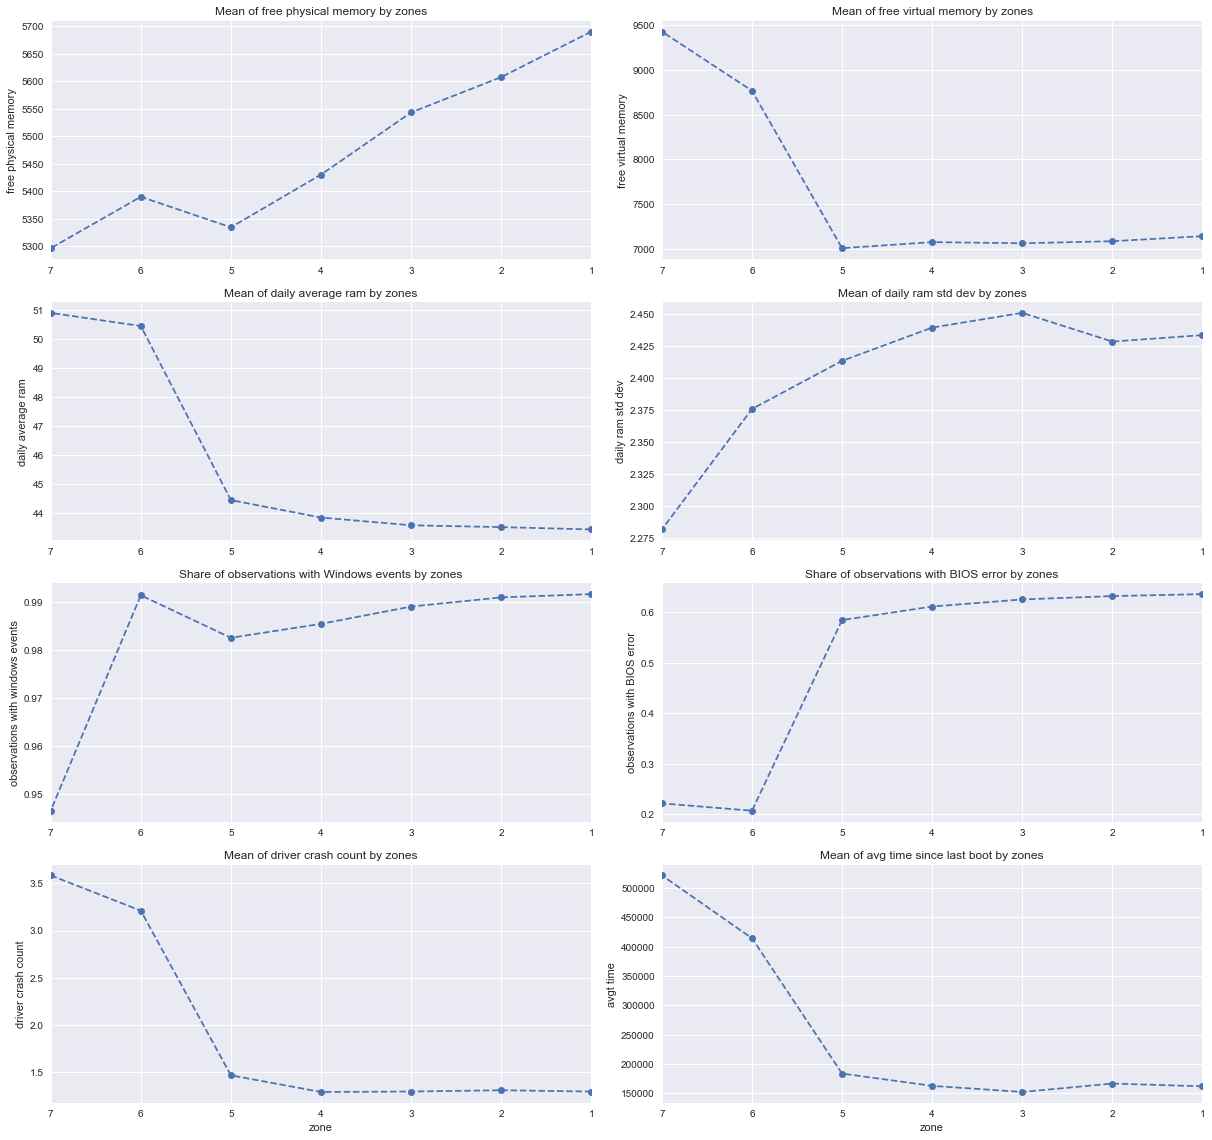

In [18]:
#Converting a 'groupby' object to a DataFrame
means = df_cleaned.groupby('zone').mean().reset_index()

#Plotting the charts
plt.figure(figsize=(17,16))
plt.subplot(4,2,1)
plt.title('Mean of free physical memory by zones')
plt.plot('zone', 'free_physical_memory', data= means, marker='o', linestyle='dashed')
plt.ylabel('free physical memory')
plt.xlim(7,1)

plt.subplot(4,2,2)
plt.title('Mean of free virtual memory by zones')
plt.plot('zone', 'free_virtual_memory', data= means, marker='o', linestyle='dashed')
plt.ylabel('free virtual memory')
plt.xlim(7,1)

plt.subplot(4,2,3)
plt.title('Mean of daily average ram by zones')
plt.plot('zone', 'daily_average_ram', data= means, marker='o', linestyle='dashed')
plt.ylabel('daily average ram')
plt.xlim(7,1)

plt.subplot(4,2,4)
plt.title('Mean of daily ram std dev by zones')
plt.plot('zone', 'daily_std_dev_ram', data= means, marker='o', linestyle='dashed')
plt.ylabel('daily ram std dev')
plt.xlim(7,1)

plt.subplot(4,2,5)
plt.title('Share of observations with Windows events by zones')
plt.plot('zone', 'windows_events_count', data= means, marker='o', linestyle='dashed')
plt.ylabel('observations with windows events')
plt.xlim(7,1)

plt.subplot(4,2,6)
plt.title('Share of observations with BIOS error by zones')
plt.plot('zone', 'has_bios_error', data= means, marker='o', linestyle='dashed')
plt.ylabel('observations with BIOS error')
plt.xlim(7,1)

plt.subplot(4,2,7)
plt.title('Mean of driver crash count by zones')
plt.plot('zone', 'driver_crash_count', data= means, marker='o', linestyle='dashed')
plt.xlabel('zone')
plt.ylabel('driver crash count')
plt.xlim(7,1)

plt.subplot(4,2,8)
plt.title('Mean of avg time since last boot by zones')
plt.plot('zone', 'average_time_since_last_boot', data= means, marker='o', linestyle='dashed')
plt.xlabel('zone')
plt.ylabel('avgt time')
plt.xlim(7,1)

plt.tight_layout() 
plt.show()

In [19]:
#Calculating Pearson's coefficient of skewness for the predictors vs. the levels of the 'zone' variable
3*(df_cleaned.groupby('zone').mean() - df_cleaned.groupby('zone').median())/df_cleaned.groupby('zone').std()

,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot
zone,,,,,,,,
1,0.787736,0.846099,0.063078,0.331193,-0.276613,-2.271587,1.104442,0.931668
2,0.746553,0.777091,0.079758,0.321594,-0.287579,-2.290909,1.084470,0.992702
3,0.701172,0.716117,0.138551,0.300646,-0.316556,-2.323492,1.049556,1.102572
4,0.653166,0.722218,0.190760,0.333714,-0.365149,-2.393476,1.045438,1.047326
5,0.568807,0.643652,0.310810,0.268911,-0.400322,-2.530610,1.052369,1.159731
6,0.817862,1.008737,0.085554,0.395095,-0.280589,1.531616,1.530614,0.979725
7,0.698515,0.808508,0.108010,0.387619,-0.712476,1.599207,1.548822,0.341087


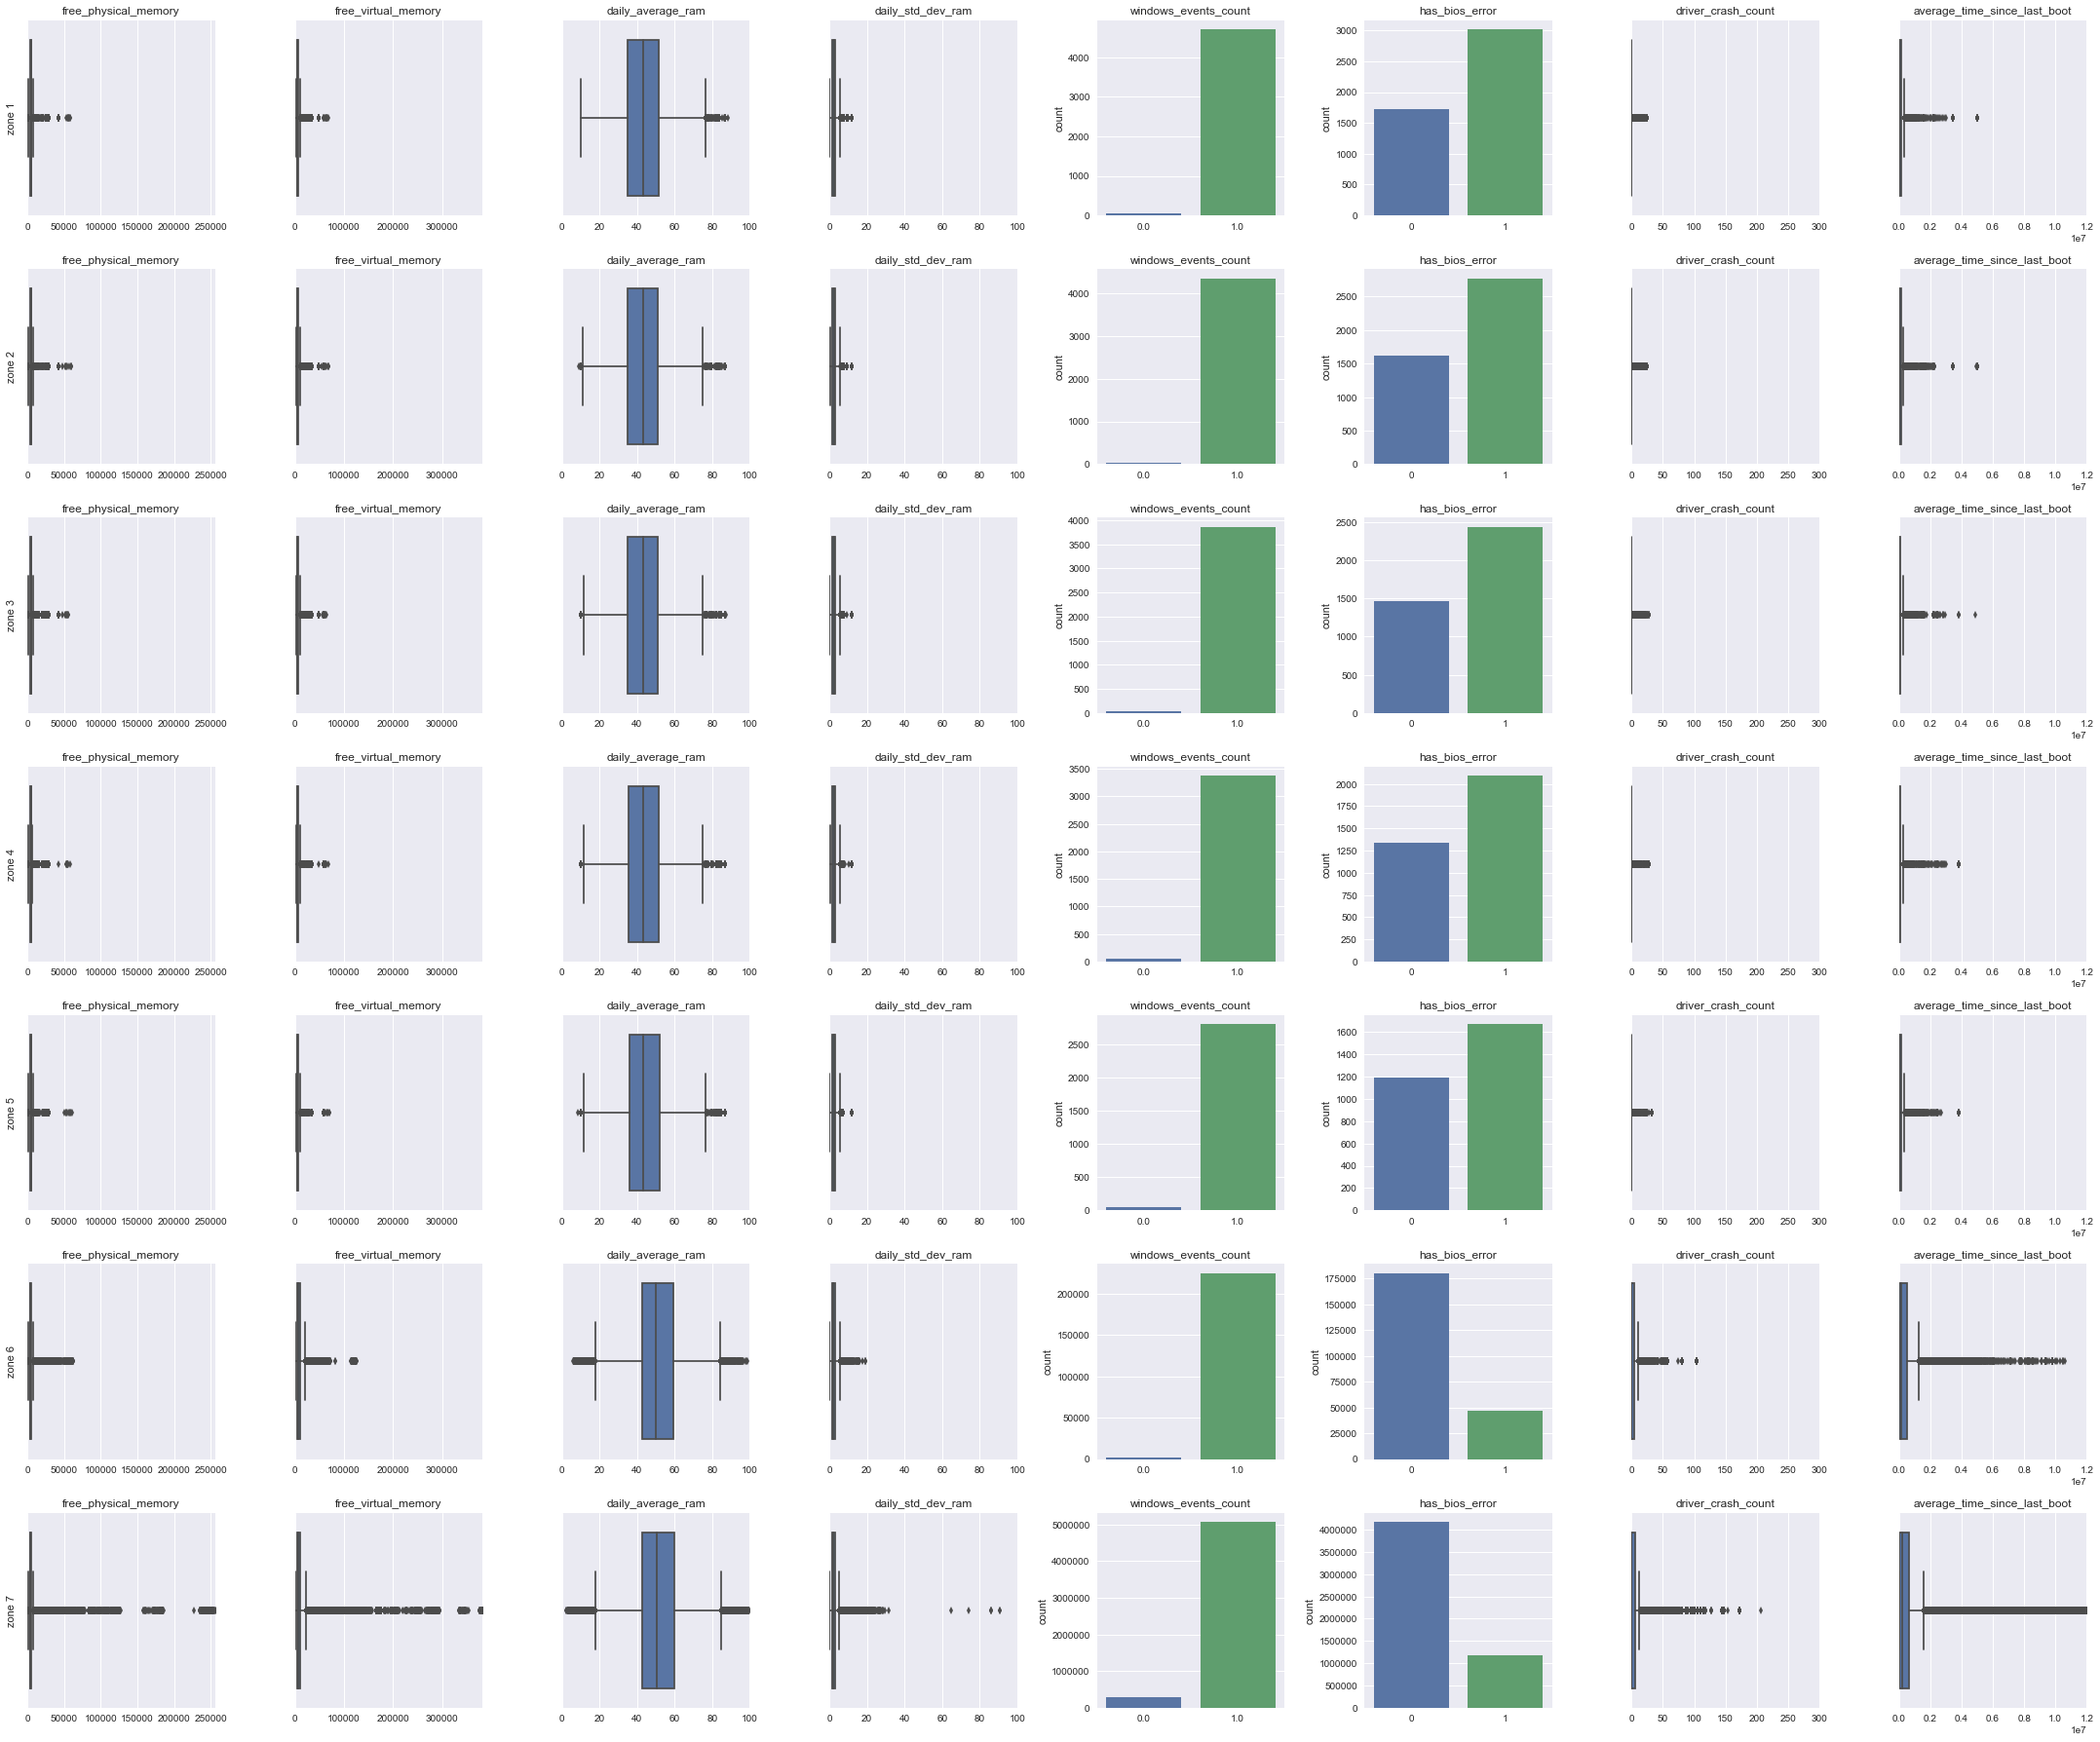

In [20]:
plt.figure(figsize=(30,25))

counter = 1
for i in range(1,8):
        
        plt.subplot(7,8,counter)
        plt.title('free_physical_memory')
        sns.boxplot(x='free_physical_memory', data=df_cleaned.loc[df_cleaned['zone'] == i])
        plt.ylabel('zone ' + str(i))
        plt.xlabel(' ')
        plt.xlim(0, 256156)
        counter += 1
        

        plt.subplot(7,8,counter)
        plt.title('free_virtual_memory')
        sns.boxplot(x='free_virtual_memory', data=df_cleaned.loc[df_cleaned['zone'] == i])
        plt.xlabel(' ')
        plt.xlim(0, 381930)
        counter += 1
        
        plt.subplot(7,8,counter)
        plt.title('daily_average_ram')
        sns.boxplot(x='daily_average_ram', data=df_cleaned.loc[df_cleaned['zone'] == i])
        plt.xlabel(' ')
        plt.xlim(0,100)
        counter += 1

        plt.subplot(7,8,counter)
        plt.title('daily_std_dev_ram')
        sns.boxplot(x='daily_std_dev_ram', data=df_cleaned.loc[df_cleaned['zone'] == i])
        plt.xlabel(' ')
        plt.xlim(0,100)
        counter += 1

        plt.subplot(7,8,counter)
        plt.title('windows_events_count')
        sns.countplot(x='windows_events_count', data=df_cleaned.loc[df_cleaned['zone'] == i])
        plt.xlabel(' ')
        counter += 1

        plt.subplot(7,8,counter)
        plt.title('has_bios_error')
        sns.countplot(x='has_bios_error', data=df_cleaned.loc[df_cleaned['zone'] == i])
        plt.xlabel(' ')
        counter += 1

        plt.subplot(7,8,counter)
        plt.title('driver_crash_count')
        sns.boxplot(x='driver_crash_count', data=df_cleaned.loc[df_cleaned['zone'] == i])
        plt.xlabel(' ')
        plt.xlim(0,300)
        counter += 1

        plt.subplot(7,8,counter)
        plt.title('average_time_since_last_boot')
        sns.boxplot(x='average_time_since_last_boot', data=df_cleaned.loc[df_cleaned['zone'] == i])
        plt.xlabel(' ')
        plt.xlim(0, 11991245)
        counter += 1

plt.tight_layout() 
plt.show()

### Statistical Analysis

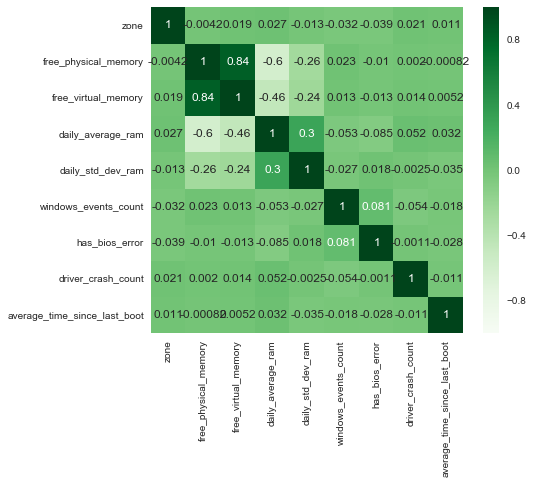

In [21]:
#Calculate correlations between the features and predictor
correlations = df_cleaned.corr()

#Make the figsize 7 x 6
plt.figure(figsize=(7,6))

#Plot heatmap of correlations
_ = sns.heatmap(correlations, cmap="Greens", annot=True)

### Downsampling the Data Set

In [22]:
#Separating zones 1 and 5
df_1_5 = df_cleaned[((df_cleaned.zone!=6) & (df_cleaned.zone!=7))]

#Separating zones 6 and 7 
df_6 = df_cleaned[df_cleaned.zone==6]
df_7 = df_cleaned[df_cleaned.zone==7]

#Downsampling zones 6-7
df_6_downsampled = resample(df_6, replace=True, n_samples=5000, random_state=42)
df_7_downsampled = resample(df_7, replace=True, n_samples=5000, random_state=42)

#Concatenating into one downsampled data frame
df_downsampled = pd.concat([df_1_5, df_6_downsampled, df_7_downsampled])

#Checking the resulting counts of observations
df_downsampled.groupby('zone').count()

,date,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot,pcid
zone,,,,,,,,,,
1,4744,4744,4744,4744,4744,4744,4744,4744,4744,4744
2,4392,4392,4392,4392,4392,4392,4392,4392,4392,4392
3,3904,3904,3904,3904,3904,3904,3904,3904,3904,3904
4,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424
5,2857,2857,2857,2857,2857,2857,2857,2857,2857,2857
6,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000
7,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000


In [23]:
#Saving into a file
df_downsampled.to_csv('downsampled_data.csv')

### Fitting the Predictive Models

#### Logistic Regression

In [24]:
#Splitting the variables into predictor and target variables. We need to drop 'pcid' and 'date' variables, 
#as those variables are not relevant for the purpose of prediction.
X = df_downsampled.drop(['zone', 'pcid', 'date'], axis=1)
y = df_downsampled.zone

#Creating a pipeline with the StandardScaler and one-vs-rest logistic regression object
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, multi_class='ovr'))

#Calculating an array of cross-validated scores
scores = cross_val_score(pipeline, X, y, cv=10)

#Displaying the mean prediction accuracy for 95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.27 (+/- 0.02)


In [25]:
#Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#Fitting the model
pipeline.fit(X_train, y_train)

#Creating the classification report
print(classification_report(y_test, pipeline.predict(X_test)))

             precision    recall  f1-score   support

          1       0.22      0.63      0.33      1424
          2       0.00      0.00      0.00      1318
          3       0.00      0.00      0.00      1171
          4       0.00      0.00      0.00      1027
          5       0.00      0.00      0.00       857
          6       0.25      0.54      0.35      1500
          7       0.40      0.42      0.41      1500

avg / total       0.15      0.27      0.18      8797



/Users/abdarabdar/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
cohen_kappa_score(y_test, pipeline.predict(X_test))

0.118656708017986

In [27]:
#Setting up the pipeline
pipeline_dummy = make_pipeline(StandardScaler(), DummyClassifier(random_state=42))

#Calculating an array of cross-validated scores
scores_dummy = cross_val_score(pipeline_dummy, X, y, cv=10)

#Displaying the mean prediction accuracy for 95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_dummy.mean(), scores_dummy.std() * 2))

Accuracy: 0.15 (+/- 0.01)


#### Random Forest and Gradient Boosting

In [28]:
#Setting up pipelines with a StandardScaler function to normalize the variables
pipelines = {
    'rf' : make_pipeline(StandardScaler(), 
                         RandomForestClassifier(random_state=42, class_weight='balanced')),
    'gb' : make_pipeline(StandardScaler(), 
                         GradientBoostingClassifier(random_state=42))
}

#Setting up the "rule of thumb" hyperparameters for the Random Forest
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

#Setting up the "rule of thumb" hyperparameters for the Gradient Boost
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

#Creating the dictionary of hyperparameters
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

#Creating an empty dictionary for fitted models
fitted_alternative_models = {}

# Looping through model pipelines, tuning each with GridSearchCV and saving it to fitted_logreg_models
for name, pipeline in pipelines.items():
    #Creating cross-validation object from pipeline and hyperparameters
    alt_model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    #Fitting the model on X_train, y_train
    alt_model.fit(X_train, y_train)
    
    #Storing the model in fitted_logreg_models[name] 
    fitted_alternative_models[name] = alt_model
    
    #Printing the status of the fitting
    print(name, 'has been fitted.')

rf has been fitted.
gb has been fitted.


In [29]:
#Displaying the best_score_ for each fitted model
for name, model in fitted_alternative_models.items():
    print(name, model.best_score_ )

rf 0.3819430910153966
gb 0.3546092379653089


In [34]:
#Creating an empty dictionary for predicted models
predicted_alternative_models = {}

#Predicting the response variables and displaying the prediction score
for name, model in fitted_alternative_models.items():
    y_pred = model.predict(X_test)
    predicted_alternative_models[name] = accuracy_score(y_test, y_pred)

predicted_alternative_models

{'gb': 0.3414800500170513, 'rf': 0.3779697624190065}

In [35]:
fitted_alternative_models['rf'].best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [36]:
#Creating the confusion matrix
pd.crosstab(y_test, fitted_alternative_models['rf'].predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,3,4,5,6,7,All
True,,,,,,,,
1,394,199,194,193,298,78,68,1424
2,214,265,226,198,306,58,51,1318
3,89,105,261,279,356,41,40,1171
4,35,41,171,254,435,45,46,1027
5,13,8,93,258,387,50,48,857
6,35,13,6,13,17,878,538,1500
7,23,9,5,7,4,566,886,1500
All,803,640,956,1202,1803,1716,1677,8797


In [37]:
#Creating the classification report
print(classification_report(y_test, fitted_alternative_models['rf'].predict(X_test)))

             precision    recall  f1-score   support

          1       0.49      0.28      0.35      1424
          2       0.41      0.20      0.27      1318
          3       0.27      0.22      0.25      1171
          4       0.21      0.25      0.23      1027
          5       0.21      0.45      0.29       857
          6       0.51      0.59      0.55      1500
          7       0.53      0.59      0.56      1500

avg / total       0.40      0.38      0.37      8797



In [38]:
cohen_kappa_score(y_test, fitted_alternative_models['rf'].predict(X_test))

0.2751692113620605

#### Neural Network Model

In [81]:
#Setting the seed
np.random.seed(42)

#Separating predictors into a variable
X_upd = df_downsampled.drop(['zone', 'pcid', 'date'], axis=1)

#Standardazing the predictors
scaler = StandardScaler()
predictors = pd.DataFrame(scaler.fit_transform(X_upd)).as_matrix()

#"One hot" encode for zones and converstion to dummy features 
target = to_categorical(df_downsampled.zone.astype(int) - 1, num_classes=7)

#Defining input shape
n_cols=predictors.shape[1]
    
#Defining the model
def nn_model():
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='softmax'))
    #Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=nn_model, epochs=10, batch_size=10, verbose=0)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

results = cross_val_score(estimator, predictors, target, cv=kfold)

print("Accuracy score: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 27.25% (0.60%)


In [92]:
#Setting the seed
np.random.seed(42)

#Defining the model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

import keras.backend as K
def top_k_categorical_accuracy(y_true, y_pred, k=5):
     return K.mean(K.in_top_k(y_pred, K.argmax(y_true, axis=-1), k), axis=-1)

#Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[top_k_categorical_accuracy, 'accuracy'])

#whether to shuffle the training data before each epoch
fitted_model = model.fit(predictors, target, validation_split=0.33, epochs=50, batch_size=10, shuffle=True, verbose=0)

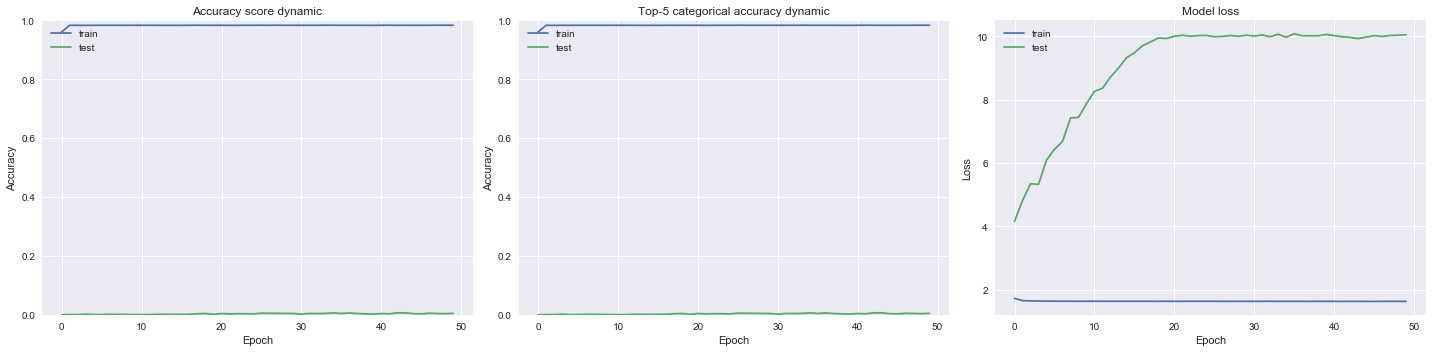

In [103]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
#Plotting accuracy score for train and validation sets
plt.plot(fitted_model.history['top_k_categorical_accuracy'])
plt.plot(fitted_model.history['val_top_k_categorical_accuracy'])
plt.title('Accuracy score dynamic')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,2)
#Plotting top-5 categorical accuracy for train and validation sets
plt.plot(fitted_model.history['top_k_categorical_accuracy'])
plt.plot(fitted_model.history['val_top_k_categorical_accuracy'])
plt.title('Top-5 categorical accuracy dynamic')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,3)
#Plotting loss function dynamic for train and validation sets
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout() 
plt.show()

In [101]:
#Setting the seed
np.random.seed(42)

#Defining the model
model2 = Sequential()
model2.add(Dense(10, activation='relu', input_shape=(n_cols,)))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(7, activation='softmax'))

import keras.backend as K
def top_k_categorical_accuracy(y_true, y_pred, k=5):
     return K.mean(K.in_top_k(y_pred, K.argmax(y_true, axis=-1), k), axis=-1)

#Compiling the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[top_k_categorical_accuracy, 'accuracy'])

#whether to shuffle the training data before each epoch
fitted_model2 = model2.fit(predictors, target, validation_split=0.4, epochs=50, batch_size=10, shuffle=True, verbose=0)

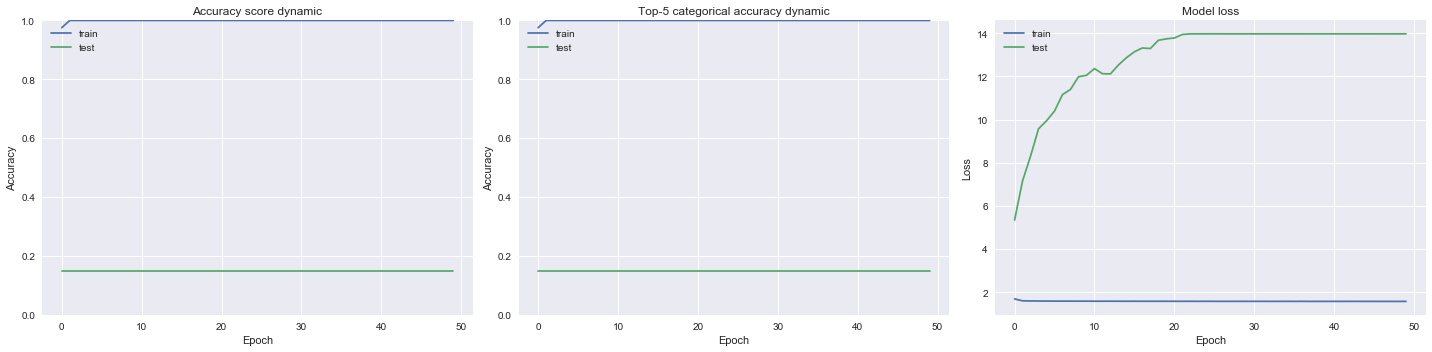

In [104]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
#Plotting accuracy score for train and validation sets
plt.plot(fitted_model2.history['top_k_categorical_accuracy'])
plt.plot(fitted_model2.history['val_top_k_categorical_accuracy'])
plt.title('Accuracy score dynamic')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,2)
#Plotting top-5 categorical accuracy for train and validation sets
plt.plot(fitted_model2.history['top_k_categorical_accuracy'])
plt.plot(fitted_model2.history['val_top_k_categorical_accuracy'])
plt.title('Top-5 categorical accuracy dynamic')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,3)
#Plotting loss function dynamic for train and validation sets
plt.plot(fitted_model2.history['loss'])
plt.plot(fitted_model2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout() 
plt.show()